In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [3]:
os.chdir('/content/gdrive/MyDrive/Case Study(m5-forecasting-accuracy)/')

In [4]:
def reduce_mem_usage(df, verbose=False):
    '''
    reduce memory usage by downcasting data types
    from https://www.kaggle.com/harupy/m5-baseline
    '''
    
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [5]:
data=pd.read_pickle('final_data.pkl').pipe(reduce_mem_usage)
data.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,...,lag_21,lag_28,lag_30,lag_45,lag_60,lag_80,expanding_sold_mean,daily_avg_sold,avg_sold,selling_trend
6098000,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1501,0,2015-03-09,11506,...,0.0,0.0,2.0,0.0,2.0,0.0,0.646973,0.0,0.669434,-0.669434
6098001,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1501,1,2015-03-09,11506,...,0.0,0.0,0.0,0.0,0.0,1.0,0.318359,1.0,0.304932,0.695312


In [6]:
from tqdm import tqdm
for col in tqdm(['id','item_id','dept_id','cat_id','store_id','state_id','event_name_1','event_type_1','event_type_2','event_name_2','weekday']):
    data[col] = data[col].astype('category')

100%|██████████| 11/11 [00:17<00:00,  1.56s/it]


In [7]:
d_id = dict(zip(data.id.cat.codes, data.id))
d_item_id = dict(zip(data.item_id.cat.codes, data.item_id))
d_dept_id = dict(zip(data.dept_id.cat.codes, data.dept_id))
d_cat_id = dict(zip(data.cat_id.cat.codes, data.cat_id))
d_store_id = dict(zip(data.store_id.cat.codes, data.store_id))
d_state_id = dict(zip(data.state_id.cat.codes, data.state_id))

In [8]:
cols = data.dtypes.index.tolist()
d_types = data.dtypes.values.tolist()
for i,type in enumerate(d_types):
    if type.name == 'category':
        data[cols[i]] = data[cols[i]].cat.codes

In [6]:
data.drop(['date'],axis=1,inplace=True)

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error as mse
import joblib
from lightgbm import LGBMRegressor

In [11]:
os.chdir('LGBM_Regressor/')

In [12]:
!pwd

/content/gdrive/MyDrive/Case Study(m5-forecasting-accuracy)/LGBM_Regressor


In [13]:
!ls

lgbm_submission.csv  model_CA_3.pkl  model_TX_2.pkl  model_WI_2.pkl
model_CA_1.pkl	     model_CA_4.pkl  model_TX_3.pkl  model_WI_3.pkl
model_CA_2.pkl	     model_TX_1.pkl  model_WI_1.pkl


# 1) LGBM Regressor

In [14]:
from tqdm import tqdm
import gc
evaluation=pd.DataFrame()
validation=pd.DataFrame()
valid_preds={}
eval_preds={}
stores = d_store_id.keys()
for store in tqdm(stores):
    df = data[data['store_id']==store]
    #Split the data
    X_train, y_train = df[df['d']<1914].drop('demand',axis=1), df[df['d']<1914]['demand']
    X_valid, y_valid = df[(df['d']>=1914) & (df['d']<1942)].drop('demand',axis=1), df[(df['d']>=1914) & (df['d']<1942)]['demand']
    X_test = df[df['d']>=1942].drop('demand',axis=1)
    
    #Train and validate
    model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=8,
        num_leaves=50,
        min_child_weight=300
    )
    print('*****Prediction for Store: {}*****'.format(d_store_id[store]))
    model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
             eval_metric='rmse', verbose=20, early_stopping_rounds=20)
    y_pred_valid=model.predict(X_valid)
    y_pred_eval=model.predict(X_test)
    X_valid['predict']=y_pred_valid
    X_test['predict']=y_pred_eval
    X_valid=X_valid[['id','d','predict']]
    validation=validation.append(X_valid)
    evaluation=evaluation.append(X_test)
    filename = 'model_'+str(d_store_id[store])+'.pkl'
    # save model
    joblib.dump(model, filename)
    del model, X_train, y_train, X_valid, y_valid
    gc.collect()

  0%|          | 0/10 [00:00<?, ?it/s]

*****Prediction for Store: CA_1*****
Training until validation scores don't improve for 20 rounds.
[20]	training's rmse: 0.291699	training's l2: 0.0850884	valid_1's rmse: 0.203341	valid_1's l2: 0.0413474
[40]	training's rmse: 0.280973	training's l2: 0.078946	valid_1's rmse: 0.203287	valid_1's l2: 0.0413257
Early stopping, best iteration is:
[22]	training's rmse: 0.290451	training's l2: 0.0843619	valid_1's rmse: 0.200764	valid_1's l2: 0.0403061


 10%|█         | 1/10 [00:19<02:57, 19.71s/it]

*****Prediction for Store: CA_2*****
Training until validation scores don't improve for 20 rounds.
[20]	training's rmse: 0.248316	training's l2: 0.0616607	valid_1's rmse: 0.224221	valid_1's l2: 0.0502751
[40]	training's rmse: 0.242364	training's l2: 0.0587404	valid_1's rmse: 0.21826	valid_1's l2: 0.0476374
[60]	training's rmse: 0.236784	training's l2: 0.0560665	valid_1's rmse: 0.215637	valid_1's l2: 0.0464993
[80]	training's rmse: 0.231683	training's l2: 0.0536771	valid_1's rmse: 0.211101	valid_1's l2: 0.0445635
[100]	training's rmse: 0.227335	training's l2: 0.0516811	valid_1's rmse: 0.210061	valid_1's l2: 0.0441257
[120]	training's rmse: 0.224062	training's l2: 0.0502038	valid_1's rmse: 0.208748	valid_1's l2: 0.0435755
Early stopping, best iteration is:
[111]	training's rmse: 0.225693	training's l2: 0.0509374	valid_1's rmse: 0.208283	valid_1's l2: 0.0433818


 20%|██        | 2/10 [00:50<03:29, 26.17s/it]

*****Prediction for Store: CA_3*****
Training until validation scores don't improve for 20 rounds.
[20]	training's rmse: 0.574191	training's l2: 0.329695	valid_1's rmse: 0.390472	valid_1's l2: 0.152468
[40]	training's rmse: 0.554861	training's l2: 0.30787	valid_1's rmse: 0.379818	valid_1's l2: 0.144261
[60]	training's rmse: 0.541867	training's l2: 0.29362	valid_1's rmse: 0.37047	valid_1's l2: 0.137248
[80]	training's rmse: 0.526732	training's l2: 0.277447	valid_1's rmse: 0.366427	valid_1's l2: 0.134268
[100]	training's rmse: 0.517159	training's l2: 0.267453	valid_1's rmse: 0.362848	valid_1's l2: 0.131658
[120]	training's rmse: 0.507515	training's l2: 0.257572	valid_1's rmse: 0.361399	valid_1's l2: 0.130609
Early stopping, best iteration is:
[111]	training's rmse: 0.511104	training's l2: 0.261227	valid_1's rmse: 0.359402	valid_1's l2: 0.12917


 30%|███       | 3/10 [01:17<03:06, 26.57s/it]

*****Prediction for Store: CA_4*****
Training until validation scores don't improve for 20 rounds.
[20]	training's rmse: 0.198424	training's l2: 0.039372	valid_1's rmse: 0.111311	valid_1's l2: 0.0123901
Early stopping, best iteration is:
[18]	training's rmse: 0.198782	training's l2: 0.0395143	valid_1's rmse: 0.110829	valid_1's l2: 0.0122832


 40%|████      | 4/10 [01:29<02:05, 20.93s/it]

*****Prediction for Store: TX_1*****
Training until validation scores don't improve for 20 rounds.
[20]	training's rmse: 0.283072	training's l2: 0.0801298	valid_1's rmse: 0.172032	valid_1's l2: 0.0295949
Early stopping, best iteration is:
[13]	training's rmse: 0.289911	training's l2: 0.0840482	valid_1's rmse: 0.169585	valid_1's l2: 0.0287589


 50%|█████     | 5/10 [01:42<01:29, 17.92s/it]

*****Prediction for Store: TX_2*****
Training until validation scores don't improve for 20 rounds.
[20]	training's rmse: 0.335465	training's l2: 0.112537	valid_1's rmse: 0.196703	valid_1's l2: 0.0386921
Early stopping, best iteration is:
[13]	training's rmse: 0.34472	training's l2: 0.118832	valid_1's rmse: 0.190704	valid_1's l2: 0.0363679


 60%|██████    | 6/10 [01:54<01:03, 15.90s/it]

*****Prediction for Store: TX_3*****
Training until validation scores don't improve for 20 rounds.
[20]	training's rmse: 0.2754	training's l2: 0.075845	valid_1's rmse: 0.218831	valid_1's l2: 0.047887
[40]	training's rmse: 0.266591	training's l2: 0.0710705	valid_1's rmse: 0.216829	valid_1's l2: 0.0470149
Early stopping, best iteration is:
[30]	training's rmse: 0.270984	training's l2: 0.0734322	valid_1's rmse: 0.215019	valid_1's l2: 0.0462333


 70%|███████   | 7/10 [02:08<00:46, 15.38s/it]

*****Prediction for Store: WI_1*****
Training until validation scores don't improve for 20 rounds.
[20]	training's rmse: 0.138257	training's l2: 0.019115	valid_1's rmse: 0.0918032	valid_1's l2: 0.00842783
[40]	training's rmse: 0.125123	training's l2: 0.0156558	valid_1's rmse: 0.081771	valid_1's l2: 0.0066865
[60]	training's rmse: 0.119012	training's l2: 0.0141639	valid_1's rmse: 0.0795313	valid_1's l2: 0.00632523
[80]	training's rmse: 0.114982	training's l2: 0.0132209	valid_1's rmse: 0.0778874	valid_1's l2: 0.00606645
[100]	training's rmse: 0.112504	training's l2: 0.0126571	valid_1's rmse: 0.0763899	valid_1's l2: 0.00583541
[120]	training's rmse: 0.109537	training's l2: 0.0119983	valid_1's rmse: 0.0759886	valid_1's l2: 0.00577427
Early stopping, best iteration is:
[111]	training's rmse: 0.110715	training's l2: 0.0122578	valid_1's rmse: 0.0755194	valid_1's l2: 0.00570319


 80%|████████  | 8/10 [02:33<00:37, 18.51s/it]

*****Prediction for Store: WI_2*****
Training until validation scores don't improve for 20 rounds.
[20]	training's rmse: 0.405908	training's l2: 0.164761	valid_1's rmse: 0.408653	valid_1's l2: 0.166998
[40]	training's rmse: 0.394123	training's l2: 0.155333	valid_1's rmse: 0.404897	valid_1's l2: 0.163942
Early stopping, best iteration is:
[31]	training's rmse: 0.398128	training's l2: 0.158506	valid_1's rmse: 0.40359	valid_1's l2: 0.162885


 90%|█████████ | 9/10 [02:48<00:17, 17.22s/it]

*****Prediction for Store: WI_3*****
Training until validation scores don't improve for 20 rounds.
[20]	training's rmse: 0.411451	training's l2: 0.169292	valid_1's rmse: 0.369016	valid_1's l2: 0.136173
[40]	training's rmse: 0.395304	training's l2: 0.156265	valid_1's rmse: 0.353801	valid_1's l2: 0.125175
[60]	training's rmse: 0.387096	training's l2: 0.149843	valid_1's rmse: 0.346258	valid_1's l2: 0.119895
[80]	training's rmse: 0.381198	training's l2: 0.145312	valid_1's rmse: 0.338958	valid_1's l2: 0.114893
[100]	training's rmse: 0.37572	training's l2: 0.141165	valid_1's rmse: 0.335338	valid_1's l2: 0.112452
[120]	training's rmse: 0.370165	training's l2: 0.137022	valid_1's rmse: 0.333696	valid_1's l2: 0.111353
[140]	training's rmse: 0.363265	training's l2: 0.131962	valid_1's rmse: 0.325509	valid_1's l2: 0.105956
[160]	training's rmse: 0.359653	training's l2: 0.12935	valid_1's rmse: 0.322615	valid_1's l2: 0.104081
[180]	training's rmse: 0.354102	training's l2: 0.125388	valid_1's rmse: 0.3

100%|██████████| 10/10 [03:34<00:00, 21.41s/it]


In [17]:
os.chdir('/content/gdrive/MyDrive/Case Study(m5-forecasting-accuracy)/LGBM_Regressor')

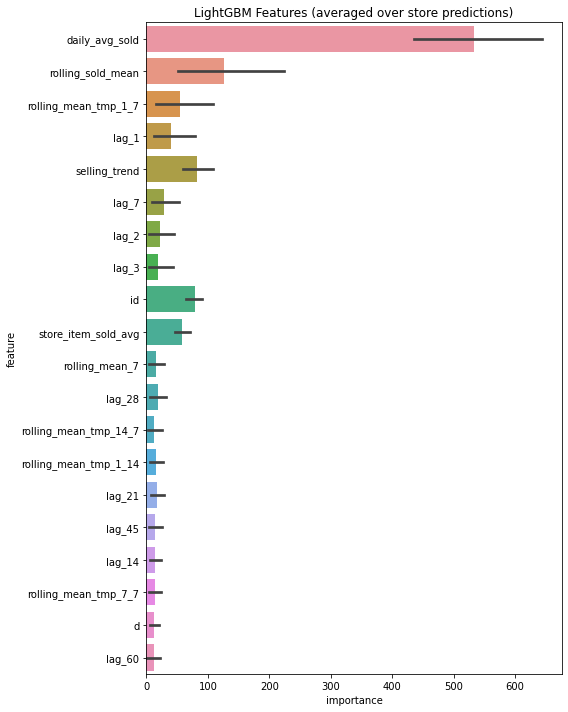

In [18]:
import os
feature_importance_df = pd.DataFrame()
features = [f for f in data.columns if f != 'demand']
for filename in os.listdir('/content/gdrive/MyDrive/Case Study(m5-forecasting-accuracy)/LGBM_Regressor'):
    if 'model' in filename:
        # load model
        model = joblib.load(filename)
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (averaged over store predictions)')
    plt.tight_layout()
    
display_importances(feature_importance_df)

In [16]:
actual = True
if actual == False:
    #Get the validation results(We already have them as less than one month left for competition to end)
    validation = data[(data['d']>=1914) & (data['d']<=1941)][['id','d','demand']]
    validation = pd.pivot(validation, index='id', columns='d', values='demand').reset_index()
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
    validation.id = validation.id.map(d_id).str.replace('evaluation','validation')
else:
    #Get the actual validation results
    validation = validation[['id','d','predict']]
    validation = pd.pivot(validation, index='id', columns='d', values='predict').reset_index()
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
    validation.id = validation.id.map(d_id).str.replace('evaluation','validation')
validation.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,2,0,0,0,0,1,1,0,6,...,2,3,1,0,0,0,1,0,0,0
1,FOODS_1_001_CA_2_validation,0,3,0,0,0,1,4,0,0,...,1,0,0,1,1,0,0,1,2,0
2,FOODS_1_001_CA_3_validation,1,0,1,0,8,1,0,0,1,...,1,2,2,0,0,1,0,3,2,2
3,FOODS_1_001_CA_4_validation,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,1,1,0,0,0
4,FOODS_1_001_TX_1_validation,0,0,1,0,1,0,1,1,1,...,1,1,1,1,5,0,2,2,0,2


In [17]:
evaluation=evaluation[['id','d','predict']]
evaluation['id']=evaluation['id'].map(d_id)
evaluation = pd.pivot(evaluation, index='id', columns='d', values='predict').reset_index()
evaluation.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]
evaluation.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.001038,0.001038,0.001038,0.001038,0.001038,0.001038,0.001038,0.001038,0.001038,...,0.001038,0.001038,0.001038,0.001038,0.001038,0.001038,0.001038,0.001038,0.001038,0.001038
1,FOODS_1_001_CA_2_evaluation,0.000226,0.000226,0.000226,0.000226,0.000226,0.000226,0.000226,0.000226,0.000226,...,0.000226,0.000226,0.000226,0.000226,0.000226,0.000226,0.000226,0.000226,0.000226,0.000226
2,FOODS_1_001_CA_3_evaluation,0.001016,0.001016,0.001016,0.001016,0.001016,0.001016,0.001016,0.001016,0.001016,...,0.001016,0.001016,0.001016,0.001016,0.001016,0.001016,0.001016,0.001016,0.001016,0.001016
3,FOODS_1_001_CA_4_evaluation,0.001310,0.001310,0.001310,0.001310,0.001310,0.001310,0.001310,0.001310,0.001310,...,0.001310,0.001310,0.001310,0.001310,0.001310,0.001310,0.001310,0.001310,0.001310,0.001310
4,FOODS_1_001_TX_1_evaluation,0.010077,0.010077,0.010077,0.010077,0.010077,0.010077,0.010077,0.010077,0.010077,...,0.010077,0.010077,0.010077,0.010077,0.010077,0.010077,0.010077,0.010077,0.010077,0.010077


In [18]:
submit = pd.concat([validation,evaluation]).reset_index(drop=True)
submit.to_csv('lgbm_submission.csv',index=False)

# 2) CatBoost Regessor

In [25]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 21 kB/s 


In [19]:
os.chdir('../.')

In [21]:
#os.mkdir('CatBoost_Regressor')
os.chdir('CatBoost_Regressor')

In [22]:
from catboost import CatBoostRegressor
import gc
valid_preds={}
eval_preds={}
evaluation=pd.DataFrame()
validation=pd.DataFrame()
stores = d_store_id.keys()
for store in tqdm(stores):
    df = data[data['store_id']==store]
    #Split the data
    X_train, y_train = df[df['d']<1914].drop('demand',axis=1), df[df['d']<1914]['demand']
    X_valid, y_valid = df[(df['d']>=1914) & (df['d']<1942)].drop('demand',axis=1), df[(df['d']>=1914) & (df['d']<1942)]['demand']
    X_test = df[df['d']>=1942].drop('demand',axis=1)
    
    #Train and validate
    model = CatBoostRegressor(
        random_state = 69,
        loss_function='RMSE',
        eval_metric='RMSE',
        leaf_estimation_method ='Newton', 
        bootstrap_type='Bernoulli'
    )
    print('*****Prediction for Store: {}*****'.format(d_store_id[store]))
    model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)], verbose=20, early_stopping_rounds=20)
    y_pred_valid=model.predict(X_valid)
    y_pred_eval=model.predict(X_test)
    X_valid['predict']=y_pred_valid
    X_test['predict']=y_pred_eval
    X_valid=X_valid[['id','d','predict']]
    validation=validation.append(X_valid)
    evaluation=evaluation.append(X_test)
    filename = 'model_'+str(d_store_id[store])+'.pkl'
    # save model
    joblib.dump(model, filename)
    del model, X_train, y_train, X_valid, y_valid
    gc.collect()

  0%|          | 0/10 [00:00<?, ?it/s]

*****Prediction for Store: CA_1*****
0:	learn: 3.5054270	test: 3.5054270	test1: 3.4958927	best: 3.4958927 (0)	total: 302ms	remaining: 5m 2s
20:	learn: 1.9953245	test: 1.9953245	test1: 1.9731373	best: 1.9731373 (20)	total: 3.89s	remaining: 3m 1s
40:	learn: 1.1445185	test: 1.1445185	test1: 1.1127970	best: 1.1127970 (40)	total: 7.63s	remaining: 2m 58s
60:	learn: 0.6667946	test: 0.6667946	test1: 0.6303994	best: 0.6303994 (60)	total: 11.3s	remaining: 2m 54s
80:	learn: 0.3975029	test: 0.3975029	test1: 0.3582284	best: 0.3582284 (80)	total: 14.9s	remaining: 2m 49s
100:	learn: 0.2494797	test: 0.2494797	test1: 0.2058657	best: 0.2058657 (100)	total: 18.4s	remaining: 2m 44s
120:	learn: 0.1737374	test: 0.1737374	test1: 0.1259936	best: 0.1259936 (120)	total: 21.9s	remaining: 2m 39s
140:	learn: 0.1432340	test: 0.1432340	test1: 0.0976796	best: 0.0976796 (140)	total: 25.3s	remaining: 2m 34s
160:	learn: 0.1188507	test: 0.1188507	test1: 0.0737609	best: 0.0737609 (160)	total: 29s	remaining: 2m 31s
180:	le

 10%|█         | 1/10 [03:29<31:24, 209.35s/it]

*****Prediction for Store: CA_2*****
0:	learn: 2.8939023	test: 2.8939023	test1: 3.0823376	best: 3.0823376 (0)	total: 205ms	remaining: 3m 25s
20:	learn: 1.6469981	test: 1.6469981	test1: 1.7480151	best: 1.7480151 (20)	total: 3.89s	remaining: 3m 1s
40:	learn: 0.9435614	test: 0.9435614	test1: 0.9952335	best: 0.9952335 (40)	total: 7.59s	remaining: 2m 57s
60:	learn: 0.5466682	test: 0.5466682	test1: 0.5679109	best: 0.5679109 (60)	total: 11.1s	remaining: 2m 51s
80:	learn: 0.3206777	test: 0.3206777	test1: 0.3238456	best: 0.3238456 (80)	total: 14.6s	remaining: 2m 45s
100:	learn: 0.1940373	test: 0.1940373	test1: 0.1857041	best: 0.1857041 (100)	total: 18s	remaining: 2m 40s
120:	learn: 0.1238182	test: 0.1238182	test1: 0.1088255	best: 0.1088255 (120)	total: 21.6s	remaining: 2m 37s
140:	learn: 0.0850329	test: 0.0850329	test1: 0.0666453	best: 0.0666453 (140)	total: 25s	remaining: 2m 32s
160:	learn: 0.0640944	test: 0.0640944	test1: 0.0448043	best: 0.0448043 (160)	total: 28.4s	remaining: 2m 27s
180:	lea

 20%|██        | 2/10 [05:07<19:13, 144.21s/it]

*****Prediction for Store: CA_3*****
0:	learn: 5.2732020	test: 5.2732020	test1: 4.6752527	best: 4.6752527 (0)	total: 163ms	remaining: 2m 43s
20:	learn: 3.0197992	test: 3.0197992	test1: 2.6517726	best: 2.6517726 (20)	total: 3.6s	remaining: 2m 47s
40:	learn: 1.7389411	test: 1.7389411	test1: 1.5088370	best: 1.5088370 (40)	total: 7.11s	remaining: 2m 46s
60:	learn: 1.0103648	test: 1.0103648	test1: 0.8575448	best: 0.8575448 (60)	total: 10.7s	remaining: 2m 44s
80:	learn: 0.5958662	test: 0.5958662	test1: 0.4948227	best: 0.4948227 (80)	total: 14.2s	remaining: 2m 40s
100:	learn: 0.3622335	test: 0.3622335	test1: 0.2878950	best: 0.2878950 (100)	total: 17.7s	remaining: 2m 37s
120:	learn: 0.2303998	test: 0.2303998	test1: 0.1701169	best: 0.1701169 (120)	total: 21.3s	remaining: 2m 34s
140:	learn: 0.1561125	test: 0.1561125	test1: 0.1040239	best: 0.1040239 (140)	total: 24.8s	remaining: 2m 30s
160:	learn: 0.1176269	test: 0.1176269	test1: 0.0721752	best: 0.0721752 (160)	total: 28.1s	remaining: 2m 26s
180:

 30%|███       | 3/10 [08:21<19:27, 166.77s/it]

*****Prediction for Store: CA_4*****
0:	learn: 1.8689473	test: 1.8689473	test1: 1.9030193	best: 1.9030193 (0)	total: 195ms	remaining: 3m 14s
20:	learn: 1.0585111	test: 1.0585111	test1: 1.0642804	best: 1.0642804 (20)	total: 4.02s	remaining: 3m 7s
40:	learn: 0.6057746	test: 0.6057746	test1: 0.5959665	best: 0.5959665 (40)	total: 7.61s	remaining: 2m 58s
60:	learn: 0.3527579	test: 0.3527579	test1: 0.3369615	best: 0.3369615 (60)	total: 11.2s	remaining: 2m 52s
80:	learn: 0.2122647	test: 0.2122647	test1: 0.1896684	best: 0.1896684 (80)	total: 14.7s	remaining: 2m 46s
100:	learn: 0.1367712	test: 0.1367712	test1: 0.1085385	best: 0.1085385 (100)	total: 18.2s	remaining: 2m 41s
120:	learn: 0.0974382	test: 0.0974382	test1: 0.0647580	best: 0.0647580 (120)	total: 21.7s	remaining: 2m 37s
140:	learn: 0.0816618	test: 0.0816618	test1: 0.0510068	best: 0.0510068 (140)	total: 25.6s	remaining: 2m 35s
160:	learn: 0.0693001	test: 0.0693001	test1: 0.0396082	best: 0.0396082 (160)	total: 29.2s	remaining: 2m 32s
180:

 40%|████      | 4/10 [09:55<13:48, 138.08s/it]

*****Prediction for Store: TX_1*****
0:	learn: 2.8949160	test: 2.8949160	test1: 3.0326945	best: 3.0326945 (0)	total: 174ms	remaining: 2m 53s
20:	learn: 1.6477852	test: 1.6477852	test1: 1.7041588	best: 1.7041588 (20)	total: 3.77s	remaining: 2m 55s
40:	learn: 0.9445743	test: 0.9445743	test1: 0.9628242	best: 0.9628242 (40)	total: 7.32s	remaining: 2m 51s
60:	learn: 0.5494613	test: 0.5494613	test1: 0.5443105	best: 0.5443105 (60)	total: 10.8s	remaining: 2m 46s
80:	learn: 0.3295543	test: 0.3295543	test1: 0.3114221	best: 0.3114221 (80)	total: 14.2s	remaining: 2m 40s
100:	learn: 0.2073142	test: 0.2073142	test1: 0.1799304	best: 0.1799304 (100)	total: 17.6s	remaining: 2m 36s
120:	learn: 0.1384257	test: 0.1384257	test1: 0.1063168	best: 0.1063168 (120)	total: 20.9s	remaining: 2m 32s
140:	learn: 0.0993329	test: 0.0993329	test1: 0.0660711	best: 0.0660711 (140)	total: 24.3s	remaining: 2m 28s
160:	learn: 0.0784004	test: 0.0784004	test1: 0.0465168	best: 0.0465168 (160)	total: 29.5s	remaining: 2m 33s
180

 50%|█████     | 5/10 [11:54<10:55, 131.10s/it]

*****Prediction for Store: TX_2*****
0:	learn: 3.6971416	test: 3.6971416	test1: 3.5929553	best: 3.5929553 (0)	total: 180ms	remaining: 2m 59s
20:	learn: 2.1093888	test: 2.1093888	test1: 2.0173647	best: 2.0173647 (20)	total: 3.68s	remaining: 2m 51s
40:	learn: 1.2121412	test: 1.2121412	test1: 1.1364684	best: 1.1364684 (40)	total: 7.2s	remaining: 2m 48s
60:	learn: 0.7015019	test: 0.7015019	test1: 0.6407102	best: 0.6407102 (60)	total: 10.7s	remaining: 2m 44s
80:	learn: 0.4118370	test: 0.4118370	test1: 0.3656859	best: 0.3656859 (80)	total: 14.1s	remaining: 2m 40s
100:	learn: 0.2453911	test: 0.2453911	test1: 0.2091202	best: 0.2091202 (100)	total: 17.5s	remaining: 2m 36s
120:	learn: 0.1498007	test: 0.1498007	test1: 0.1205632	best: 0.1205632 (120)	total: 20.9s	remaining: 2m 31s
140:	learn: 0.0964157	test: 0.0964157	test1: 0.0714624	best: 0.0714624 (140)	total: 24.1s	remaining: 2m 27s
160:	learn: 0.0666352	test: 0.0666352	test1: 0.0451455	best: 0.0451455 (160)	total: 27.4s	remaining: 2m 22s
180:

 60%|██████    | 6/10 [14:38<09:28, 142.23s/it]

*****Prediction for Store: TX_3*****
0:	learn: 3.5502268	test: 3.5502268	test1: 3.5180638	best: 3.5180638 (0)	total: 200ms	remaining: 3m 19s
20:	learn: 2.0196127	test: 2.0196127	test1: 1.9847959	best: 1.9847959 (20)	total: 3.73s	remaining: 2m 53s
40:	learn: 1.1566199	test: 1.1566199	test1: 1.1290316	best: 1.1290316 (40)	total: 7.3s	remaining: 2m 50s
60:	learn: 0.6695302	test: 0.6695302	test1: 0.6479429	best: 0.6479429 (60)	total: 10.8s	remaining: 2m 45s
80:	learn: 0.3932453	test: 0.3932453	test1: 0.3714395	best: 0.3714395 (80)	total: 14.2s	remaining: 2m 41s
100:	learn: 0.2377905	test: 0.2377905	test1: 0.2117543	best: 0.2117543 (100)	total: 17.6s	remaining: 2m 36s
120:	learn: 0.1516267	test: 0.1516267	test1: 0.1227466	best: 0.1227466 (120)	total: 21s	remaining: 2m 32s
140:	learn: 0.1072151	test: 0.1072151	test1: 0.0782706	best: 0.0782701 (139)	total: 24.3s	remaining: 2m 28s
160:	learn: 0.0904330	test: 0.0904330	test1: 0.0636607	best: 0.0636607 (160)	total: 28s	remaining: 2m 26s
180:	lea

 70%|███████   | 7/10 [16:42<06:49, 136.36s/it]

*****Prediction for Store: WI_1*****
0:	learn: 2.4876825	test: 2.4876825	test1: 2.5047802	best: 2.5047802 (0)	total: 177ms	remaining: 2m 56s
20:	learn: 1.4048691	test: 1.4048691	test1: 1.4053096	best: 1.4053096 (20)	total: 3.9s	remaining: 3m 1s
40:	learn: 0.7969881	test: 0.7969881	test1: 0.7893191	best: 0.7893191 (40)	total: 7.69s	remaining: 2m 59s
60:	learn: 0.4538456	test: 0.4538456	test1: 0.4444069	best: 0.4444069 (60)	total: 11.5s	remaining: 2m 57s
80:	learn: 0.2615402	test: 0.2615402	test1: 0.2516860	best: 0.2516860 (80)	total: 15.2s	remaining: 2m 52s
100:	learn: 0.1529672	test: 0.1529672	test1: 0.1433106	best: 0.1433106 (100)	total: 18.9s	remaining: 2m 48s
120:	learn: 0.0911912	test: 0.0911912	test1: 0.0825583	best: 0.0825583 (120)	total: 22.3s	remaining: 2m 42s
140:	learn: 0.0565941	test: 0.0565941	test1: 0.0491174	best: 0.0491174 (140)	total: 25.8s	remaining: 2m 37s
160:	learn: 0.0378759	test: 0.0378759	test1: 0.0309480	best: 0.0309480 (160)	total: 29.3s	remaining: 2m 32s
180:	

 80%|████████  | 8/10 [18:30<04:14, 127.38s/it]

*****Prediction for Store: WI_2*****
0:	learn: 4.0122931	test: 4.0122931	test1: 4.7867455	best: 4.7867455 (0)	total: 202ms	remaining: 3m 21s
20:	learn: 2.2874892	test: 2.2874892	test1: 2.7133747	best: 2.7133747 (20)	total: 3.72s	remaining: 2m 53s
40:	learn: 1.3116067	test: 1.3116067	test1: 1.5494379	best: 1.5494379 (40)	total: 7.35s	remaining: 2m 51s
60:	learn: 0.7581379	test: 0.7581379	test1: 0.8902403	best: 0.8902403 (60)	total: 10.9s	remaining: 2m 48s
80:	learn: 0.4441634	test: 0.4441634	test1: 0.5139939	best: 0.5139939 (80)	total: 14.4s	remaining: 2m 43s
100:	learn: 0.2671191	test: 0.2671191	test1: 0.3006021	best: 0.3006021 (100)	total: 17.8s	remaining: 2m 38s
120:	learn: 0.1680268	test: 0.1680268	test1: 0.1796769	best: 0.1796769 (120)	total: 21.3s	remaining: 2m 34s
140:	learn: 0.1141295	test: 0.1141295	test1: 0.1156850	best: 0.1156850 (140)	total: 24.6s	remaining: 2m 29s
160:	learn: 0.0910692	test: 0.0910692	test1: 0.0892711	best: 0.0892711 (160)	total: 27.9s	remaining: 2m 25s
180

 90%|█████████ | 9/10 [20:26<02:03, 123.92s/it]

*****Prediction for Store: WI_3*****
0:	learn: 3.4702617	test: 3.4702617	test1: 3.7075575	best: 3.7075575 (0)	total: 196ms	remaining: 3m 16s
20:	learn: 1.9824705	test: 1.9824705	test1: 2.1052357	best: 2.1052357 (20)	total: 3.7s	remaining: 2m 52s
40:	learn: 1.1415863	test: 1.1415863	test1: 1.1912984	best: 1.1912984 (40)	total: 7.21s	remaining: 2m 48s
60:	learn: 0.6696844	test: 0.6696844	test1: 0.6732201	best: 0.6732201 (60)	total: 10.7s	remaining: 2m 45s
80:	learn: 0.4087004	test: 0.4087004	test1: 0.3830073	best: 0.3830073 (80)	total: 14.2s	remaining: 2m 40s
100:	learn: 0.2679753	test: 0.2679753	test1: 0.2212080	best: 0.2212080 (100)	total: 17.7s	remaining: 2m 37s
120:	learn: 0.1951640	test: 0.1951640	test1: 0.1394175	best: 0.1394175 (120)	total: 21.4s	remaining: 2m 35s
140:	learn: 0.1599384	test: 0.1599384	test1: 0.1101721	best: 0.1101721 (140)	total: 25.1s	remaining: 2m 33s
160:	learn: 0.1386851	test: 0.1386851	test1: 0.1033215	best: 0.1032819 (158)	total: 30.6s	remaining: 2m 39s
180:

100%|██████████| 10/10 [21:35<00:00, 129.59s/it]


In [22]:
os.chdir('/content/gdrive/MyDrive/Case Study(m5-forecasting-accuracy)/CatBoost_Regressor')

In [23]:
!pwd

/content/gdrive/MyDrive/Case Study(m5-forecasting-accuracy)/CatBoost_Regressor


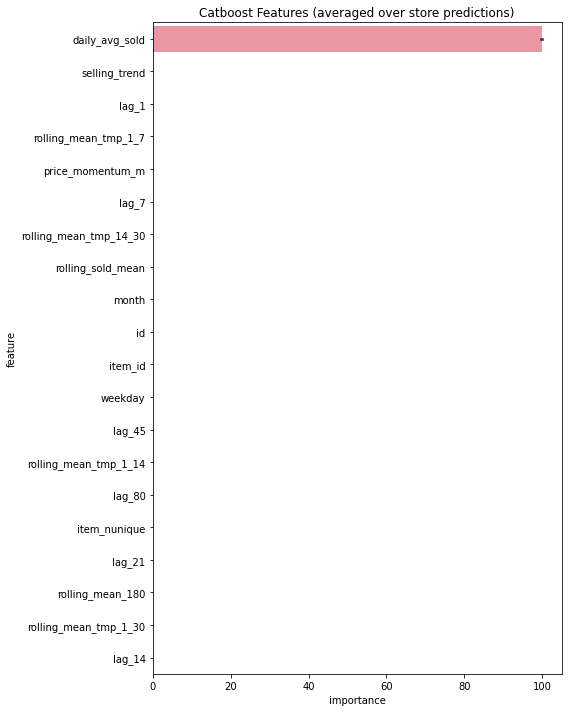

In [26]:
import os
feature_importance_df = pd.DataFrame()
features = [f for f in data.columns if f != 'demand']
for filename in os.listdir('/content/gdrive/MyDrive/Case Study(m5-forecasting-accuracy)/CatBoost_Regressor'):
    if 'model' in filename:
        # load model
        model = joblib.load(filename)
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Catboost Features (averaged over store predictions)')
    plt.tight_layout()
    
display_importances(feature_importance_df)

In [24]:
validation = validation[['id','d','predict']]
validation = pd.pivot(validation, index='id', columns='d', values='predict').reset_index()
validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
validation.id = validation.id.map(d_id).str.replace('evaluation','validation')
validation.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,2.000081,0.000857,-0.000144,0.001000,0.000369,1.000484,1.000848,0.001434,5.998942,...,1.999652,3.000074,1.000928,0.000913,0.000848,-0.000171,1.000845,0.000353,0.001544,0.000945
1,FOODS_1_001_CA_2_validation,0.004744,2.996817,0.004042,0.004641,0.004329,1.001188,3.993504,0.004699,0.004228,...,0.998410,0.003854,0.003166,0.999179,0.998942,0.002091,0.002577,0.998842,1.996606,0.003583
2,FOODS_1_001_CA_3_validation,0.999051,0.001981,0.999959,0.003221,7.995672,1.000320,0.002184,0.003244,0.998159,...,0.998336,1.999439,1.999670,0.000737,0.001084,0.997475,0.002024,2.998984,1.999423,1.998804
3,FOODS_1_001_CA_4_validation,0.003056,1.001407,0.002338,0.002415,0.002514,0.003387,1.001882,0.003275,0.002622,...,1.000846,0.003445,0.003117,0.002824,0.002424,1.000713,1.001153,0.002420,0.003496,0.003104
4,FOODS_1_001_TX_1_validation,0.001522,0.000938,0.998842,0.000908,0.999535,0.001619,1.000301,0.999346,0.999403,...,1.000162,1.000797,1.000992,1.000593,4.987517,0.001635,1.998737,1.997815,0.002642,1.998303


In [25]:
evaluation=evaluation[['id','d','predict']]
evaluation['id']=evaluation['id'].map(d_id)
evaluation = pd.pivot(evaluation, index='id', columns='d', values='predict').reset_index()
evaluation.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]
evaluation.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.000856,0.000903,-0.000171,0.000951,0.000378,0.001515,0.000975,0.000015,0.001162,...,0.000963,0.001654,0.001056,0.000932,0.000914,-0.000280,0.001007,0.000711,0.001571,0.000075
1,FOODS_1_001_CA_2_evaluation,0.003438,0.002633,0.001841,0.002441,0.002391,0.003038,0.002773,0.002773,0.002519,...,0.002603,0.003108,0.002852,0.002739,0.002439,0.002070,0.002288,0.002358,0.002984,0.002632
2,FOODS_1_001_CA_3_evaluation,0.001198,0.000727,0.003226,0.000655,0.001813,0.002503,0.002304,0.000851,0.000937,...,0.000790,0.001816,0.001548,0.000857,0.001311,0.000554,0.001838,0.000490,0.001517,0.001116
3,FOODS_1_001_CA_4_evaluation,0.002963,0.002562,0.002253,0.002222,0.002404,0.003304,0.002964,0.002559,0.002425,...,0.002307,0.003292,0.002948,0.002790,0.002372,0.002141,0.002159,0.002260,0.003241,0.002772
4,FOODS_1_001_TX_1_evaluation,0.002027,0.001927,0.001777,0.001670,0.001706,0.002116,0.002267,0.002275,0.001480,...,0.001193,0.002088,0.001840,0.001821,0.001106,0.000943,0.000855,0.001138,0.001756,0.001541


In [26]:
submit = pd.concat([validation,evaluation]).reset_index(drop=True)
submit.to_csv('catboost_submission.csv',index=False)

In [27]:
!ls

catboost_info		 model_CA_2.pkl  model_TX_1.pkl  model_WI_1.pkl
catboost_submission.csv  model_CA_3.pkl  model_TX_2.pkl  model_WI_2.pkl
model_CA_1.pkl		 model_CA_4.pkl  model_TX_3.pkl  model_WI_3.pkl


# XGBoostRegressor

In [11]:
!pwd

/content/gdrive/MyDrive/Case Study(m5-forecasting-accuracy)


In [12]:
try:
  os.mkdir('XGB_Regressor')
except OSError:
  pass
os.chdir('XGB_Regressor')

In [13]:
!pwd

/content/gdrive/MyDrive/Case Study(m5-forecasting-accuracy)/XGB_Regressor


In [14]:
from xgboost import XGBRegressor
import gc
valid_preds={}
eval_preds={}
evaluation=pd.DataFrame()
validation=pd.DataFrame()
stores = d_store_id.keys()
for store in tqdm(stores):
    df = data[data['store_id']==store]
    #Split the data
    X_train, y_train = df[df['d']<1914].drop('demand',axis=1), df[df['d']<1914]['demand']
    X_valid, y_valid = df[(df['d']>=1914) & (df['d']<1942)].drop('demand',axis=1), df[(df['d']>=1914) & (df['d']<1942)]['demand']
    X_test = df[df['d']>=1942].drop('demand',axis=1)
    
    #Train and validate
    model = XGBRegressor(
        learning_rate=0.1,
        n_estimators=1000,
        max_depth=3,
        min_child_weight=3,
        gamma=0,
        subsample=0.8,
        reg_alpha=200, reg_lambda=200,
        nthread=4,
        eval_metric='rmse'
    )
    print('*****Prediction for Store: {}*****'.format(d_store_id[store]))
    model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)], early_stopping_rounds=20)
    y_pred_valid=model.predict(X_valid)
    y_pred_eval=model.predict(X_test)
    X_valid['predict']=y_pred_valid
    X_test['predict']=y_pred_eval
    X_valid=X_valid[['id','d','predict']]
    validation=validation.append(X_valid)
    evaluation=evaluation.append(X_test)
    filename = 'model_'+str(d_store_id[store])+'.pkl'
    # save model
    joblib.dump(model, filename)
    del model, X_train, y_train, X_valid, y_valid
    gc.collect()

  0%|          | 0/10 [00:00<?, ?it/s]

*****Prediction for Store: CA_1*****
[07:41:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.40213	validation_1-rmse:3.41183
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:3.099	validation_1-rmse:3.10133
[2]	validation_0-rmse:2.82701	validation_1-rmse:2.82192
[3]	validation_0-rmse:2.57746	validation_1-rmse:2.56893
[4]	validation_0-rmse:2.35558	validation_1-rmse:2.34147
[5]	validation_0-rmse:2.15678	validation_1-rmse:2.13538
[6]	validation_0-rmse:1.97607	validation_1-rmse:1.94687
[7]	validation_0-rmse:1.81117	validation_1-rmse:1.77906
[8]	validation_0-rmse:1.66359	validation_1-rmse:1.62764
[9]	validation_0-rmse:1.5294	validation_1-rmse:1.48911
[10]	validation_0-rmse:1.40816	validation_1-rmse:1.36524
[11]	validation_0-rmse:1.29821	validation_1-rmse:1.25266
[12]	v

 10%|█         | 1/10 [18:24<2:45:40, 1104.45s/it]

*****Prediction for Store: CA_2*****
[07:59:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.79295	validation_1-rmse:3.02703
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:2.54272	validation_1-rmse:2.75372
[2]	validation_0-rmse:2.31961	validation_1-rmse:2.5054
[3]	validation_0-rmse:2.11883	validation_1-rmse:2.2822
[4]	validation_0-rmse:1.93525	validation_1-rmse:2.07865
[5]	validation_0-rmse:1.77007	validation_1-rmse:1.89674
[6]	validation_0-rmse:1.62237	validation_1-rmse:1.73195
[7]	validation_0-rmse:1.48782	validation_1-rmse:1.58421
[8]	validation_0-rmse:1.36959	validation_1-rmse:1.45256
[9]	validation_0-rmse:1.2593	validation_1-rmse:1.33248
[10]	validation_0-rmse:1.16031	validation_1-rmse:1.22369
[11]	validation_0-rmse:1.07098	validation_1-rmse:1.12558
[12]	v

 20%|██        | 2/10 [1:07:43<4:52:44, 2195.57s/it]

*****Prediction for Store: CA_3*****
[08:49:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.15688	validation_1-rmse:4.61177
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:4.72185	validation_1-rmse:4.20924
[2]	validation_0-rmse:4.32631	validation_1-rmse:3.84051
[3]	validation_0-rmse:3.97285	validation_1-rmse:3.50842
[4]	validation_0-rmse:3.64853	validation_1-rmse:3.20888
[5]	validation_0-rmse:3.35551	validation_1-rmse:2.93862
[6]	validation_0-rmse:3.08508	validation_1-rmse:2.6938
[7]	validation_0-rmse:2.8445	validation_1-rmse:2.47208
[8]	validation_0-rmse:2.62698	validation_1-rmse:2.27363
[9]	validation_0-rmse:2.43002	validation_1-rmse:2.09383
[10]	validation_0-rmse:2.25268	validation_1-rmse:1.92944
[11]	validation_0-rmse:2.08683	validation_1-rmse:1.78131
[12]	

 30%|███       | 3/10 [1:19:36<2:57:09, 1518.44s/it]

*****Prediction for Store: CA_4*****
[09:01:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.77016	validation_1-rmse:1.81562
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.61498	validation_1-rmse:1.64686
[2]	validation_0-rmse:1.46915	validation_1-rmse:1.49674
[3]	validation_0-rmse:1.33874	validation_1-rmse:1.35892
[4]	validation_0-rmse:1.22641	validation_1-rmse:1.23685
[5]	validation_0-rmse:1.1194	validation_1-rmse:1.12413
[6]	validation_0-rmse:1.02551	validation_1-rmse:1.02229
[7]	validation_0-rmse:0.939831	validation_1-rmse:0.931459
[8]	validation_0-rmse:0.862024	validation_1-rmse:0.848936
[9]	validation_0-rmse:0.793474	validation_1-rmse:0.774168
[10]	validation_0-rmse:0.731472	validation_1-rmse:0.707429
[11]	validation_0-rmse:0.675595	validation_1-rmse:0.6

 40%|████      | 4/10 [1:46:39<2:35:57, 1559.56s/it]

*****Prediction for Store: TX_1*****
[09:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.76594	validation_1-rmse:2.90121
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:2.52163	validation_1-rmse:2.64268
[2]	validation_0-rmse:2.30648	validation_1-rmse:2.40831
[3]	validation_0-rmse:2.11004	validation_1-rmse:2.19244
[4]	validation_0-rmse:1.93158	validation_1-rmse:2.00172
[5]	validation_0-rmse:1.77248	validation_1-rmse:1.82854
[6]	validation_0-rmse:1.62796	validation_1-rmse:1.67039
[7]	validation_0-rmse:1.49479	validation_1-rmse:1.52723
[8]	validation_0-rmse:1.37687	validation_1-rmse:1.39763
[9]	validation_0-rmse:1.26924	validation_1-rmse:1.27972
[10]	validation_0-rmse:1.17385	validation_1-rmse:1.17405
[11]	validation_0-rmse:1.08604	validation_1-rmse:1.07933
[12

 50%|█████     | 5/10 [2:05:21<1:56:49, 1401.89s/it]

*****Prediction for Store: TX_2*****
[09:46:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.55449	validation_1-rmse:3.45491
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:3.25842	validation_1-rmse:3.14442
[2]	validation_0-rmse:2.99109	validation_1-rmse:2.86484
[3]	validation_0-rmse:2.74474	validation_1-rmse:2.60884
[4]	validation_0-rmse:2.5267	validation_1-rmse:2.37722
[5]	validation_0-rmse:2.32816	validation_1-rmse:2.16637
[6]	validation_0-rmse:2.14541	validation_1-rmse:1.97698
[7]	validation_0-rmse:1.9812	validation_1-rmse:1.80602
[8]	validation_0-rmse:1.83192	validation_1-rmse:1.64773
[9]	validation_0-rmse:1.69648	validation_1-rmse:1.50344
[10]	validation_0-rmse:1.57435	validation_1-rmse:1.37399
[11]	validation_0-rmse:1.46189	validation_1-rmse:1.25549
[12]	

 60%|██████    | 6/10 [2:17:13<1:17:49, 1167.42s/it]

*****Prediction for Store: TX_3*****
[09:58:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.40603	validation_1-rmse:3.38627
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:3.11248	validation_1-rmse:3.08799
[2]	validation_0-rmse:2.84819	validation_1-rmse:2.81642
[3]	validation_0-rmse:2.60702	validation_1-rmse:2.5716
[4]	validation_0-rmse:2.39212	validation_1-rmse:2.34685
[5]	validation_0-rmse:2.19409	validation_1-rmse:2.1426
[6]	validation_0-rmse:2.0147	validation_1-rmse:1.95785
[7]	validation_0-rmse:1.85119	validation_1-rmse:1.79211
[8]	validation_0-rmse:1.70552	validation_1-rmse:1.64181
[9]	validation_0-rmse:1.57108	validation_1-rmse:1.50513
[10]	validation_0-rmse:1.45145	validation_1-rmse:1.38184
[11]	validation_0-rmse:1.33942	validation_1-rmse:1.26815
[12]	v

 70%|███████   | 7/10 [3:07:26<1:28:31, 1770.58s/it]

*****Prediction for Store: WI_1*****
[10:48:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.40419	validation_1-rmse:2.44676
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:2.17946	validation_1-rmse:2.2167
[2]	validation_0-rmse:1.98087	validation_1-rmse:2.00968
[3]	validation_0-rmse:1.80347	validation_1-rmse:1.82339
[4]	validation_0-rmse:1.63894	validation_1-rmse:1.65413
[5]	validation_0-rmse:1.49346	validation_1-rmse:1.50179
[6]	validation_0-rmse:1.36344	validation_1-rmse:1.36361
[7]	validation_0-rmse:1.24106	validation_1-rmse:1.23992
[8]	validation_0-rmse:1.13437	validation_1-rmse:1.1279
[9]	validation_0-rmse:1.0385	validation_1-rmse:1.02605
[10]	validation_0-rmse:0.950463	validation_1-rmse:0.934987
[11]	validation_0-rmse:0.869711	validation_1-rmse:0.852794
[1

 80%|████████  | 8/10 [3:50:46<1:07:49, 2034.90s/it]

*****Prediction for Store: WI_2*****
[11:32:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.86083	validation_1-rmse:4.63734
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:3.52474	validation_1-rmse:4.23718
[2]	validation_0-rmse:3.22087	validation_1-rmse:3.87162
[3]	validation_0-rmse:2.94169	validation_1-rmse:3.54273
[4]	validation_0-rmse:2.69297	validation_1-rmse:3.24199
[5]	validation_0-rmse:2.46986	validation_1-rmse:2.97135
[6]	validation_0-rmse:2.26661	validation_1-rmse:2.72599
[7]	validation_0-rmse:2.082	validation_1-rmse:2.50676
[8]	validation_0-rmse:1.91875	validation_1-rmse:2.30526
[9]	validation_0-rmse:1.76914	validation_1-rmse:2.12483
[10]	validation_0-rmse:1.63359	validation_1-rmse:1.95936
[11]	validation_0-rmse:1.50874	validation_1-rmse:1.80994
[12]	

 90%|█████████ | 9/10 [4:32:39<36:24, 2184.31s/it]  

*****Prediction for Store: WI_3*****
[12:14:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.31724	validation_1-rmse:3.56354
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:3.0329	validation_1-rmse:3.25922
[2]	validation_0-rmse:2.77827	validation_1-rmse:2.98524
[3]	validation_0-rmse:2.54963	validation_1-rmse:2.73831
[4]	validation_0-rmse:2.34383	validation_1-rmse:2.51289
[5]	validation_0-rmse:2.15486	validation_1-rmse:2.31234
[6]	validation_0-rmse:1.9848	validation_1-rmse:2.13003
[7]	validation_0-rmse:1.8323	validation_1-rmse:1.96619
[8]	validation_0-rmse:1.69518	validation_1-rmse:1.81674
[9]	validation_0-rmse:1.56795	validation_1-rmse:1.68047
[10]	validation_0-rmse:1.45359	validation_1-rmse:1.55703
[11]	validation_0-rmse:1.35241	validation_1-rmse:1.44684
[12]	v

100%|██████████| 10/10 [4:45:17<00:00, 1711.79s/it]


In [15]:
actual = True
if actual == False:
    #Get the validation results(We already have them as less than one month left for competition to end)
    validation = data[(data['d']>=1914) & (data['d']<=1941)][['id','d','demand']]
    validation = pd.pivot(validation, index='id', columns='d', values='demand').reset_index()
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
    validation.id = validation.id.map(d_id).str.replace('evaluation','validation')
else:
    #Get the actual validation results
    validation = validation[['id','d','predict']]
    validation = pd.pivot(validation, index='id', columns='d', values='predict').reset_index()
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
    validation.id = validation.id.map(d_id).str.replace('evaluation','validation')
validation.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,1.999923,0.000357,0.000357,0.000357,0.000357,0.999983,0.999983,0.000357,5.999700,...,1.999923,2.999839,0.999983,0.000357,0.000357,0.000357,0.999983,0.000357,0.000357,0.000357
1,FOODS_1_001_CA_2_validation,0.000332,2.999961,0.000332,0.000332,0.000332,0.999979,3.999746,0.000332,0.000332,...,0.999979,0.000332,0.000332,0.999979,0.999979,0.000332,0.000332,0.999979,1.999974,0.000332
2,FOODS_1_001_CA_3_validation,0.999993,0.000395,0.999993,0.000395,7.998166,0.999993,0.000395,0.000395,0.999993,...,0.999993,1.999995,1.999995,0.000395,0.000395,0.999993,0.000395,2.999952,1.999995,1.999995
3,FOODS_1_001_CA_4_validation,0.000304,0.999984,0.000304,0.000304,0.000304,0.000304,0.999984,0.000304,0.000304,...,0.999984,0.000304,0.000304,0.000304,0.000304,0.999984,0.999984,0.000304,0.000304,0.000304
4,FOODS_1_001_TX_1_validation,0.000308,0.000308,0.999946,0.000308,0.999946,0.000308,0.999946,0.999946,0.999946,...,0.999946,0.999946,0.999946,0.999946,4.999619,0.000308,1.999916,1.999916,0.000308,1.999916


In [16]:
evaluation=evaluation[['id','d','predict']]
evaluation['id']=evaluation['id'].map(d_id)
evaluation = pd.pivot(evaluation, index='id', columns='d', values='predict').reset_index()
evaluation.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]
evaluation.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.000357,0.000357,0.000357,0.000357,0.000357,0.000357,0.000357,0.000357,0.000357,...,0.000357,0.000357,0.000357,0.000357,0.000357,0.000357,0.000357,0.000357,0.000357,0.000357
1,FOODS_1_001_CA_2_evaluation,0.000332,0.000332,0.000332,0.000332,0.000332,0.000332,0.000332,0.000332,0.000332,...,0.000332,0.000332,0.000332,0.000332,0.000332,0.000332,0.000332,0.000332,0.000332,0.000332
2,FOODS_1_001_CA_3_evaluation,0.000395,0.000395,0.000395,0.000395,0.000395,0.000395,0.000395,0.000395,0.000395,...,0.000395,0.000395,0.000395,0.000395,0.000395,0.000395,0.000395,0.000395,0.000395,0.000395
3,FOODS_1_001_CA_4_evaluation,0.000304,0.000304,0.000304,0.000304,0.000304,0.000304,0.000304,0.000304,0.000304,...,0.000304,0.000304,0.000304,0.000304,0.000304,0.000304,0.000304,0.000304,0.000304,0.000304
4,FOODS_1_001_TX_1_evaluation,0.000308,0.000308,0.000308,0.000308,0.000308,0.000308,0.000308,0.000308,0.000308,...,0.000308,0.000308,0.000308,0.000308,0.000308,0.000308,0.000308,0.000308,0.000308,0.000308


In [17]:
submit = pd.concat([validation,evaluation]).reset_index(drop=True)
submit.to_csv('xgb_submission.csv',index=False)

In [29]:
del X_test
del df
del validation

In [27]:
os.chdir('../.')

In [28]:
!pwd

/content/gdrive/MyDrive/Case Study(m5-forecasting-accuracy)


In [30]:
os.chdir('/content/gdrive/MyDrive/Case Study(m5-forecasting-accuracy)/XGB_Regressor')

In [31]:
!pwd

/content/gdrive/MyDrive/Case Study(m5-forecasting-accuracy)/XGB_Regressor


In [32]:
data.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'demand', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'price_max', 'price_min',
       'price_std', 'price_mean', 'price_norm', 'price_nunique',
       'item_nunique', 'price_momentum', 'price_momentum_m',
       'price_momentum_y', 'iteam_sold_avg', 'state_sold_avg',
       'store_sold_avg', 'cat_sold_avg', 'dept_sold_avg', 'cat_dept_sold_avg',
       'store_item_sold_avg', 'cat_item_sold_avg', 'dept_item_sold_avg',
       'state_store_sold_avg', 'state_store_cat_sold_avg',
       'store_cat_dept_sold_avg', 'rolling_sold_mean', 'rolling_mean_7',
       'rolling_std_7', 'rolling_mean_14', 'rolling_std_14', 'rolling_mean_30',
       'rolling_std_30', 'rolling_mean_60', 'rolling_std_60',
       'rolling_mean_180', 'rolling_std_180', 'rolling_mean_tmp_1_7',
       'rolling_mean_tmp_

model_CA_1.pkl
[13:15:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
model_CA_2.pkl
[13:15:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
model_CA_3.pkl
[13:15:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
model_CA_4.pkl
[13:15:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
model_TX_1.pkl
[13:15:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
model_TX_2.pkl
[13:15:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
model_TX_3.pkl
[13:15:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
model_

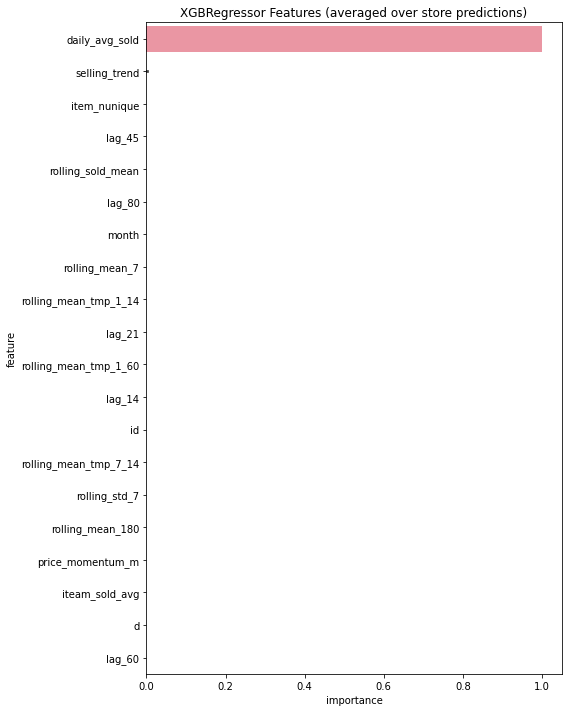

In [33]:
import os
feature_importance_df = pd.DataFrame()
features = [f for f in data.columns if f != 'demand']
for filename in os.listdir('/content/gdrive/MyDrive/Case Study(m5-forecasting-accuracy)/XGB_Regressor'):
    if 'model' in filename:
        # load model
        print(filename)
        model = joblib.load(filename)
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('XGBRegressor Features (averaged over store predictions)')
    plt.tight_layout()
    
display_importances(feature_importance_df)